In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
from matplotlib import lines
import pickle as pkl
from utils import u_plot as uplot, constants as cnst, u_darrays, u_met
import pandas as pd
import os
from utils import u_statistics as u_stat
import glob
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd /home/ck/pythonWorkspace/proj_CEH/

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def linear_trend_lingress(x, nb_missing=None, sig=None):
    
    
    coll = []
    x = x.squeeze()

    for xx in x.transpose():
    
        slope, intercept, r, p, std_err = stats.linregress(np.arange(len(xx.values)), xx.values)

        # we need to return a dataarray or else xarray's groupby won't be happy

        if nb_missing is not None:
            if np.nansum(xx.values==0)>=10:
                p = np.nan
                slope = np.nan
        
        if sig is not None:
            if p > sig:
                slope = np.nan
        
        coll.append(slope)
    
    return xr.DataArray(coll,)

In [4]:
def linear_trend_lingress_single(x, nb_missing=None, sig=None):
    
    x = x.squeeze()

    slope, intercept, r, p, std_err = stats.linregress(np.arange(len(x.values)), x.values)

        # we need to return a dataarray or else xarray's groupby won't be happy

    if nb_missing is not None:
        if np.nansum(x.values==0)>=10:
            p = np.nan
            slope = np.nan

    if sig is not None:
        if p > sig:
            slope = np.nan
        
    
    return xr.DataArray(slope,)

In [5]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['latitude', 'longitude'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [6]:
era_srfc = xr.open_dataset(cnst.ERA5_MONTHLY_SRFC_SYNOP)
era_pl = xr.open_dataset(cnst.ERA5_MONTHLY_PL_SYNOP)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_mean_5000km2.nc')
ccover40 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-40_monthly_count_-40base_1000km2.nc')
ccover50 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-50_monthly_count.nc')

In [532]:
ccover

<xarray.Dataset>
Dimensions:  (lat: 1172, lon: 1115, time: 420)
Coordinates:
  * lon      (lon) float32 -22.990005 -22.919998 -22.850006 ... 54.92 54.990005
  * lat      (lat) float32 -42.0 -41.93 -41.86 -41.79 ... 39.83 39.9 39.97
  * time     (time) datetime64[ns] 1983-01-31 1983-02-28 ... 2017-12-31
Data variables:
    tir      (time, lat, lon) float32 ...

In [533]:
era_srfc = era_srfc.where((era_srfc['t2m'])['time.hour'] == 12, drop=True)


In [534]:
era_pl = era_pl.where((era_pl['q'])['time.hour'] == 12, drop=True)

In [535]:
era_srfc = u_darrays.flip_lat(era_srfc)
era_pl = u_darrays.flip_lat(era_pl)

In [536]:
# ws_ar = u_met.u_v_to_ws_wd(era_pl['u'].values, era_pl['v'].values)
# era_pl['v'].values = ws_ar[0]

era_trend = era_pl.sel(longitude=slice(-10,10), latitude=slice(4.5,23)).mean('longitude').squeeze()
era_trend2d = era_srfc.sel(longitude=slice(-10,10), latitude=slice(4.5,23)).mean('longitude').squeeze()
ccover_trend = ccover['tir'].sel(lon=slice(-10,10), lat=slice(4.5,23))
ccover_trend40 = ccover40['tir'].sel(lon=slice(-10,10), lat=slice(4.5,23))/30
ccover_trend50 = ccover50['tir'].sel(lon=slice(-10,10), lat=slice(4.5,23))/30
# grid = ccover_trend.salem.grid.regrid(factor=0.25)
# ccover_out = grid.lookup_transform(ccover_trend)
# grid = grid.to_dataset()
# ccover_trend = xr.DataArray(ccover_out, coords=[ccover_trend['time'],  grid['y'], grid['x']], dims=['time',  'lat','lon'])
ccover_trend = ccover_trend.mean('lon').squeeze()*100
ccover_trend40 = ccover_trend40.mean('lon').squeeze()*100
ccover_trend50 = ccover_trend50.mean('lon').squeeze()*100

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [537]:
era_srfc

<xarray.Dataset>
Dimensions:    (latitude: 31, longitude: 51, time: 483)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2019-03-01T12:00:00
  * longitude  (longitude) float32 -18.5 -17.8 -17.1 -16.4 ... 15.1 15.8 16.5
  * latitude   (latitude) float32 3.5 4.2 4.9 5.6 6.3 ... 22.4 23.1 23.8 24.5
Data variables:
    u100       (time, latitude, longitude) float32 -2.002423 ... -3.1112034
    v100       (time, latitude, longitude) float32 0.45120144 ... -1.7516353
    u10        (time, latitude, longitude) float32 -1.8792205 ... -2.742859
    v10        (time, latitude, longitude) float32 0.43440962 ... -1.5623362
    d2m        (time, latitude, longitude) float32 296.19522 ... 270.46976
    t2m        (time, latitude, longitude) float32 299.0594 ... 297.29626
    blh        (time, latitude, longitude) float32 436.72205 ... 1202.3284
    cape       (time, latitude, longitude) float32 508.39124 ... -0.00012207031
    cin        (time, latitude, longitude) float32 

In [538]:
ccover_trend.values[(ccover_trend['time.month']==5) &  (ccover_trend['time.year']>=2007)] -=0.5

<xarray.DataArray 'tcwv' ()>
array(49.703125, dtype=float32) <xarray.DataArray 'tcwv' ()>
array(49.7583, dtype=float32) <xarray.DataArray 'tcwv' ()>
array(0.998891, dtype=float32)


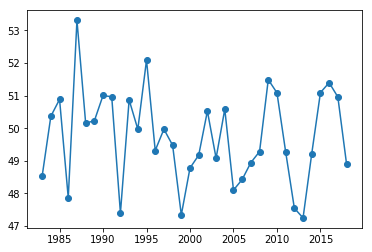

In [539]:
et = era_srfc['tcwv'].sel(latitude=slice(4.5,8), longitude=slice(-10,10)).mean(['latitude', 'longitude'])
emay = et[et['time.month']==8]
first = emay[emay['time.year']>=2007].mean('time')
second = emay[emay['time.year']<2007].mean('time')
bias = first/second
print(first, second, bias)
plt.plot(np.unique(et['time.year'])[4:-1],emay.values[4::], '-o')

In [540]:
may = ccover_trend.sel(lat=slice(4.5,8)).mean(['lat'])
may = may[may['time.month']==11]
first = may[may['time.year']>=2007].mean('time')
second = may[may['time.year']<2007].mean('time')
bias = first/second
print(first, second, bias)

<xarray.DataArray 'tir' ()>
array(0.797902, dtype=float32) <xarray.DataArray 'tir' ()>
array(0.340346, dtype=float32) <xarray.DataArray 'tir' ()>
array(2.344387, dtype=float32)


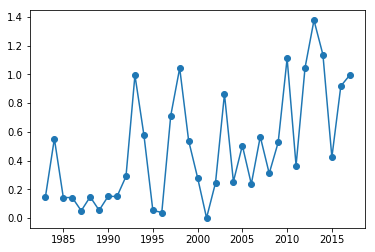

In [541]:
plt.plot(np.unique(ccover_trend['time.year']),may, '-o')

In [590]:
utrend = era_trend['u'][(era_trend['time.year']>1984)].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

tcwvtrend = era_trend2d['tcwv'][(era_trend2d['time.year']>1984)].squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

# tcwvtrend = era_trend2d['tcwv'][(era_trend2d['time.year']>1982)].squeeze().groupby('time.month'). \
# apply(linear_trend_lingress,nb_missing=10)*10

vtrend = era_trend['v'][era_trend['time.year']>1984].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

qtrend = era_trend['q'][era_trend['time.year']>1984].sel(level=slice(900,925)).mean('level').squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10*1000

qtrend_ns = era_trend['q'][era_trend['time.year']>1984].sel(level=slice(900,925)).mean('level').squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10*1000
qhigh = era_trend['q'][era_trend['time.year']>1984].sel(level=slice(699,700)).mean('level').squeeze()
qlow = era_trend['q'][era_trend['time.year']>1984].sel(level=slice(924,925)).mean('level').squeeze()
qdiff = qlow - qhigh
qmtrend = qdiff.groupby('time.month').apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10*1000

qmtrend_ns = qdiff.groupby('time.month').apply(linear_trend_lingress,nb_missing=10)*10*1000

ttrend = era_trend['t'][era_trend['time.year']>1984].sel(level=925).squeeze().groupby('time.month'). \
apply(linear_trend_lingress,nb_missing=10)*10

shear_u = era_trend['u'][era_trend['time.year']>1984].sel(level=slice(650, 651)).min(dim='level')-era_trend['u'].sel(level=slice(924,925)).max(dim='level')
shear_v = era_trend['v'][era_trend['time.year']>1984].sel(level=slice(650,651)).min(dim='level')-era_trend['v'].sel(level=slice(924,925)).max(dim='level')
ws_shear = u_met.u_v_to_ws_wd(shear_u.values, shear_v.values)
shear = era_trend['u'][era_trend['time.year']>1984].sel(level=925)
shear.name = 'shear'
shear.values = ws_shear[0]
strend_ns = shear.squeeze().groupby('time.month').apply(linear_trend_lingress,nb_missing=10)*10


div_925 = era_trend['d'][era_trend['time.year']>1984].sel(level=slice(900,950)).mean(dim='level')
q_925 = era_trend['q'][era_trend['time.year']>1984].sel(level=slice(900,950)).mean(dim='level')
qdiv =  div_925 * q_925#
qdiv_trend = qdiv.squeeze().groupby('time.month').apply(linear_trend_lingress,nb_missing=10)*10

ctrend = ccover_trend[ccover_trend['time.year']>1984].groupby('time.month').apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10
ctrend40 = ccover_trend40[ccover_trend40['time.year']>1984].groupby('time.month').apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10
ctrend50 = ccover_trend50[ccover_trend50['time.year']>1984].groupby('time.month').apply(linear_trend_lingress,nb_missing=10, sig=0.05)*10

In [573]:
np.unique((era_trend['t']['time.year']))

array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [574]:
ctrend

<xarray.DataArray (month: 12, dim_0: 264)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [0.235619, 0.253083, 0.280166, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: dim_0

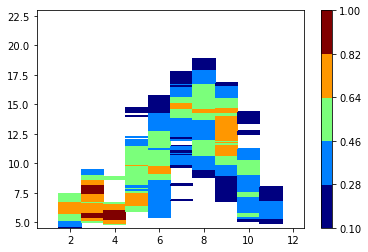

In [575]:
f = plt.figure()
ax = f.add_subplot(111)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose(),cmap=cmapp, vmin=0.1, vmax=1)
cbar = f.colorbar(mappable, ticks=np.linspace(0.1,1,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')
# -70 MCS >25000km2 trends 

In [576]:
umean = era_trend['u'][era_trend['time.year']>1984].sel(level=slice(600,700)).mean(dim='level').squeeze().groupby('time.month').mean('time')
vmean = era_trend['v'][era_trend['time.year']>1984].sel(level=slice(600,700)).mean(dim='level').squeeze().groupby('time.month').mean('time')
u6mean = era_trend['u'][era_trend['time.year']>1984].sel(level=slice(600,700)).mean(dim='level').squeeze().groupby('time.month').mean('time')
qmean = era_trend['q'][era_trend['time.year']>1984].sel(level=slice(924,925)).mean('level').squeeze().groupby('time.month').mean('time') *1000
qmmean = era_trend['q'][era_trend['time.year']>1984].sel(level=slice(650,750)).mean('level').squeeze().groupby('time.month').mean('time') *1000
tmean = era_trend['t'][era_trend['time.year']>1984].sel(level=925).squeeze().groupby('time.month').mean('time')
shearmean = shear[shear['time.year']>1984].squeeze().groupby('time.month').mean('time') #(u9mean/(umean-u9mean))*100
divmean = qdiv[shear['time.year']>1984].squeeze().groupby('time.month').mean('time')
tcwvmean = era_trend2d['tcwv'][era_trend2d['time.year']>1984].squeeze().groupby('time.month').mean('time')
#ipdb.set_trace()
aej_pos = np.argmin(u6mean.values, axis=1)

In [577]:
cmean = ccover_trend[ccover_trend['time.year']>1984].groupby('time.month').mean('time')
cmean40 = ccover_trend40[ccover_trend40['time.year']>1984].groupby('time.month').mean('time')
cmean50 = ccover_trend50[ccover_trend50['time.year']>1984].groupby('time.month').mean('time')

In [578]:
ccover['tir']

<xarray.DataArray 'tir' (time: 420, lat: 1172, lon: 1115)>
[548847600 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -22.990005 -22.919998 -22.850006 ... 54.92 54.990005
  * lat      (lat) float32 -42.0 -41.93 -41.86 -41.79 ... 39.83 39.9 39.97
  * time     (time) datetime64[ns] 1983-01-31 1983-02-28 ... 2017-12-31

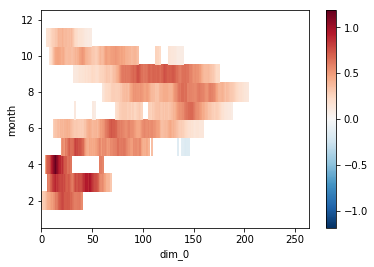

In [579]:
ctrend.plot()

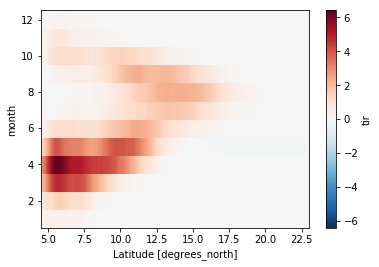

In [580]:
cmean.plot()

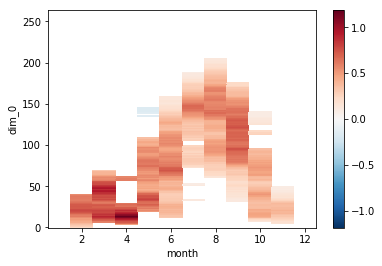

In [581]:
ctrend.T.plot()

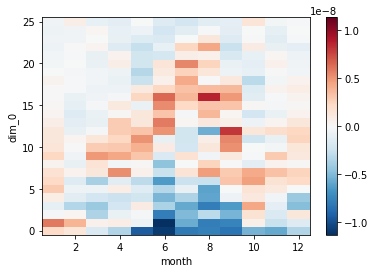

In [582]:
qdiv_trend.T.plot()

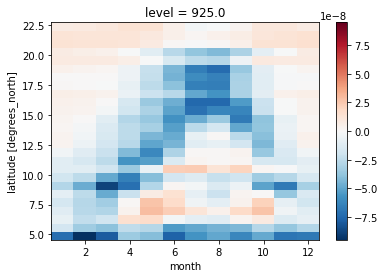

In [583]:
divmean.T.plot()


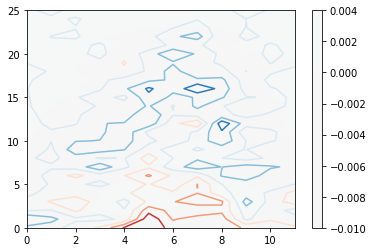

In [584]:
plt.contourf(divmean.T*100000, cmap='RdBu', vmin=-3, vmax=3)
plt.colorbar()
plt.contour(qdiv_trend.T*100000, cmap='RdBu')

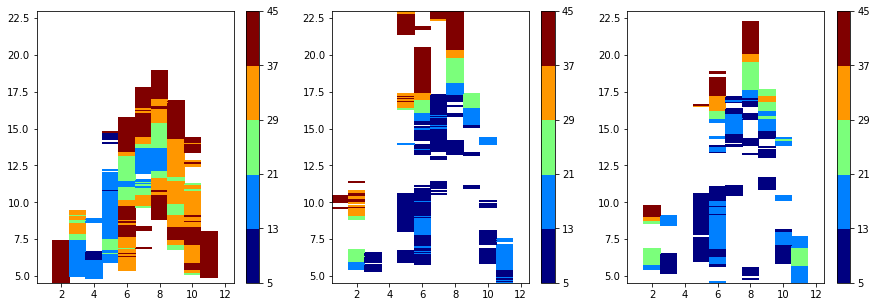

In [592]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(131)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose().values/cmean.transpose().values*100,cmap=cmapp, vmin=5, vmax=45)
cbar = f.colorbar(mappable, ticks=np.linspace(5,45,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')

ax = f.add_subplot(132)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend40.lat,ctrend40.transpose().values/cmean40.transpose().values*100,cmap=cmapp, vmin=5, vmax=45)
cbar = f.colorbar(mappable, ticks=np.linspace(5,45,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')

ax = f.add_subplot(133)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend50.lat,ctrend50.transpose().values/cmean50.transpose().values*100,cmap=cmapp, vmin=5, vmax=45)
cbar = f.colorbar(mappable, ticks=np.linspace(5,45,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')
# -70 MCS >25000km2 trends 

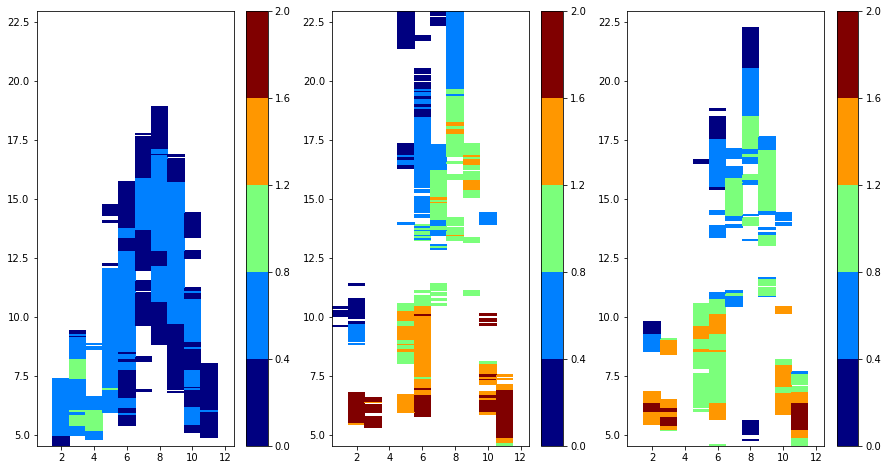

In [586]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(131)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose().values,cmap=cmapp, vmin=0, vmax=2)
cbar = f.colorbar(mappable, ticks=np.linspace(0,2,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')

ax = f.add_subplot(132)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend40.lat,ctrend40.transpose().values,cmap=cmapp, vmin=0, vmax=2)
cbar = f.colorbar(mappable, ticks=np.linspace(0,2,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')

ax = f.add_subplot(133)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend50.lat,ctrend50.transpose().values,cmap=cmapp, vmin=0, vmax=2)
cbar = f.colorbar(mappable, ticks=np.linspace(0,2,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')
# -70 MCS >25000km2 trends

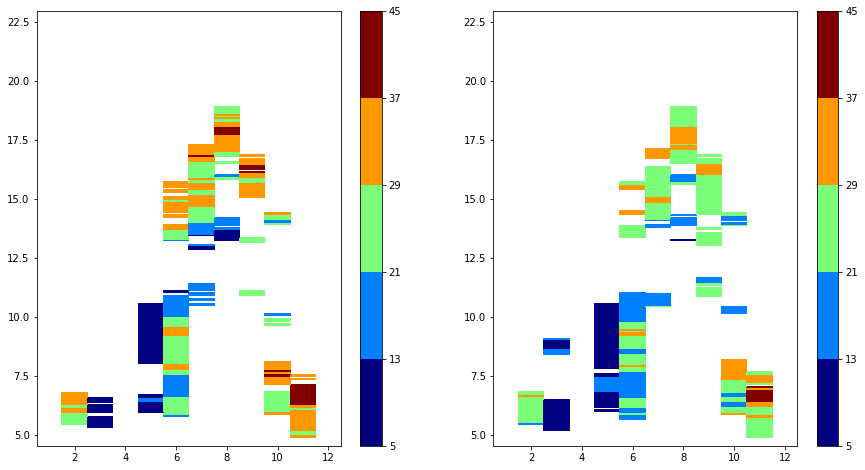

In [587]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(121)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,(ctrend.transpose().values/cmean.transpose().values*100)-(ctrend40.transpose().values/cmean40.transpose().values*100),cmap=cmapp, vmin=5, vmax=45)
cbar = f.colorbar(mappable, ticks=np.linspace(5,45,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')

ax = f.add_subplot(122)
cmapp = uplot.discrete_cmap(5, base_cmap='jet')
mappable = plt.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,(ctrend.transpose().values/cmean.transpose().values*100)-ctrend50.transpose().values/cmean50.transpose().values*100,cmap=cmapp, vmin=5, vmax=45)
cbar = f.colorbar(mappable, ticks=np.linspace(5,45,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('')

# -70 MCS >25000km2 trends 

In [588]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, x, y, title=None,  mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(x, y, data, **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(x, y, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                        cmap=contour['cmap'] ) 
        
        plt.clabel(cs, inline=1, fontsize=10)
        
    ## additional contour on plot   
    if contour2 is not None:
        cs = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                        cmap=contour2['cmap'] ) 
        
        plt.clabel(cs, inline=1, fontsize=10)
        
    plt.title(title)
    # Countries
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [559]:
contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : qtrend.transpose(), 
           'levels' : [0.1,0.2,0.3], 'cmap' : 'viridis'}
contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose(), 
           'levels' : np.linspace(-0.5,0.5,8), 'cmap' : 'Greys'}

mask_sig = (qtrend.transpose()>0.2).astype(int) 

In [560]:
mcs = cnst.GRIDSAT + 'aggs/box_13W-13E-4-8N_meanT-50_from5000km2.nc'

In [561]:
mcs_temp = xr.open_dataset(mcs)

In [562]:
tgrad_test = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
t2m = tgrad_test['t2m']
t2m = u_darrays.flip_lat(t2m)
tall = t2m.sel(longitude=slice(-12, 15), latitude=slice(5,25)).mean('longitude')

In [563]:
april = tall[tall['time.month']==5]

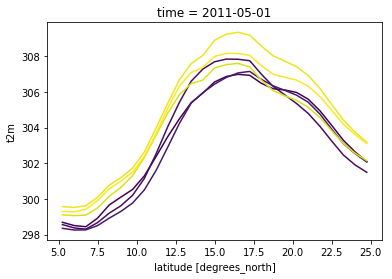

In [564]:
plt.figure()
cmap = mpl.cm.get_cmap('viridis')
ranges = np.array([0,1,2,30,31,32])
for r in ranges:
    perc = r / max(ranges)
    april[r,:].plot(color=cmap(perc))

In [7]:
def calc_month(m):
    srfc = cnst.ERA5_MONTHLY_SRFC_SYNOP
    pl = cnst.ERA5_MONTHLY_PL_SYNOP
    
    if (m < 5) | (m >= 10):  # box from where to detect max shear, max q, MCS trend variability
        box = [-12,10,4.5,8]
        mcs = cnst.GRIDSAT + 'aggs/box_12W-10E-5-8N_meanT-50_from5000km2.nc'
    else:
#         #box =[-10,12,10,25]
#         mcs = cnst.GRIDSAT + 'aggs/box_12W-15E-10-18N_meanT-50_from5000km2.nc'
        box = [-12,10,4.5,8]
        mcs = cnst.GRIDSAT + 'aggs/box_12W-10E-5-8N_meanT-50_from5000km2.nc'
    #tpick = [-10,10,6,26]
    Tlons = [-10,10]
    
    mcs_temp = xr.open_dataset(mcs)
    mcs_temp = mcs_temp['tir']   # mcs Tmean per month in the box
    
    y1 = np.min(np.unique(mcs_temp['time.year'].values))
    y2 = np.max(np.unique(mcs_temp['time.year'].values))

    das = xr.open_dataset(srfc)
    das = u_darrays.flip_lat(das)
    das = das.where((das['time.year']>=y1) & (das['time.year']<=y2) & (das['time.hour']==12), drop=True)
    dam = das['t2m']
    tsouth = dam.sel(longitude=slice(Tlons[0], Tlons[1]), latitude=slice(5,8)).mean('longitude')  # temperature gradient detection
    tnorth = dam.sel(longitude=slice(-10, 20), latitude=slice(10,22)).mean('longitude')
    tall = dam.sel(longitude=slice(-10, 20), latitude=slice(5,22)).mean('longitude')
    
    da_orig = xr.open_dataset(pl)
    da_orig = u_darrays.flip_lat(da_orig)
    da_orig = da_orig.where((da_orig['time.year']>=y1) & (da_orig['time.year']<=y2) & (dam['time.hour']==12), drop=True)
    da = da_orig.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    
    u925 = da['u'].sel(level=slice(900, 925)).mean(dim='level').mean('longitude')
    u600 = da['u'].sel(level=slice(600, 650)).mean(dim='level').mean('longitude') 
    v925 = da['v'].sel(level=slice(900, 925)).mean(dim='level').mean('longitude')
    v600 = da['v'].sel(level=slice(600, 650)).mean(dim='level').mean('longitude')
    qq925 = da['q'].sel(level=slice(875,950)).mean(dim='level').mean('longitude')*1000
    qq600 = da['q'].sel(level=slice(600, 700)).mean(dim='level').mean('longitude')*1000
#     tt925 = da['t'].sel(level=slice(900,950)).mean(dim='level').mean('longitude')
#     tt600 = da['t'].sel(level=slice(600, 700)).mean(dim='level').mean('longitude')
    
#     theta925 = u_met.theta_e(925,tt925.values-273.15,qq925.values)
#     theta600 = u_met.theta_e(650,tt925.values-273.15,qq600.values)
    
    #thetadiff = theta925-theta600
    #qq925.values = thetadiff
    #qq925 = das['tcwv'].sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3])).mean('longitude')
    
    months = [1,2,3,4,5,6,7,8,9,10,11,12]
    mnames = {1:'Jan',2:'Feb', 3 : 'Mar', 4 : 'April', 5 : 'May', 6:'Jun', 7:'Jul', 8:'Aug', 9 : 'Sep', 10 : 'Oct', 11:'Nov', 12:'Dec'}

    # pick month
    south = tsouth[(tsouth['time.month']==m)]
    north = tnorth[(tnorth['time.month']==m)]
    alls = tall[(tall['time.month']==m)]
    ulow = u925[(u925['time.month']==m)]
    uhigh = u600[(u600['time.month']==m)]
    
    vlow = v925[(v925['time.month']==m)]
    vhigh = v600[(v600['time.month']==m)]
    mcs_month = mcs_temp[mcs_temp['time.month']==m]
    qlow = qq925[(qq925['time.month']==m)]
    qmid = qq600[(qq600['time.month'] == m)]
    
    if m == 5:
        mcs_month.values[mcs_month['time.year']>=2007] +=1
    
    south_peryear = south.groupby('time.year').mean('time').min('latitude') # minimum T in south box per year
    north_peryear = north.groupby('time.year').mean('time').max('latitude') # maximum T in north box per year
    qlow_peryear = qlow.groupby('time.year').mean('time').mean('latitude') # max q in box per year
    qmid_peryear = qmid.groupby('time.year').mean('time').max('latitude') # max q in box pear year
    
    tmax_loc = np.argmax(alls.mean('time').values)
    print('Tmax_loc', tmax_loc, alls.latitude.values[tmax_loc])
    alls = alls.isel(latitude=slice(0,tmax_loc))
    tslope_peryear = alls.squeeze().groupby('time.year').apply(linear_trend_lingress_single,nb_missing=10)

    tslopes = tslope_peryear * (np.max(alls.latitude.values)-np.min(alls.latitude.values))
    tdiff = alls.squeeze().groupby('time.year').max()-alls.squeeze().groupby('time.year').min()
    

    
    u925_peryear = ulow.groupby('time.year').mean('time')
    u600_peryear = uhigh.groupby('time.year').mean('time')
    v925_peryear = vlow.groupby('time.year').mean('time')
    v600_peryear = vhigh.groupby('time.year').mean('time')
    q = qlow_peryear
    qmid = qmid_peryear

    ### check where AEJ would be 
    da_movshear = da_orig.sel(longitude=slice(box[0], box[1]), latitude=slice(3,20))
    u600_mov = da_movshear['u'].sel(level=slice(600,700)).mean(dim='level').mean(['longitude'])
    uhigh_mov = u600_mov[(u600_mov['time.month']==m)]
    uhigh_mov = uhigh_mov.groupby('time.year').mean('time')

    aej_speed = uhigh_mov.min('latitude')
    aej_lat = []
    for uh in uhigh_mov:
        pos = np.argmin(uh.values)
        aej_lat.append(uh.latitude.values[pos])
    aej_lat = np.mean(aej_lat)
    #####
    
    tgrad = ((north_peryear-south_peryear))
    print('Mean tgrad', np.mean(tgrad.values))
    
#     plt.figure()
#     plt.plot(alls['time.year'].values, tslopes, label='slope')
#     plt.plot(alls['time.year'].values,tdiff, label='diff')
#     plt.plot(alls['time.year'].values,tgrad, label='northsouth')
#     plt.legend()
    
    ushear =u600_peryear-u925_peryear
    vshear =v600_peryear-v925_peryear
    
    shear = tgrad.copy(deep=True)
    shear.name = 'shear'
    uwind = tgrad.copy(deep=True)
    uwind.name = 'u'
    maxshear = []
    shearlat = []
    minu = []
    for us, vs in zip(ushear, vshear):
        ws_shear = u_met.u_v_to_ws_wd(us.values, vs.values)
        maxshear.append(np.max(ws_shear[0]))
        shearlat.append(ushear.latitude.values[np.argmax(ws_shear[0])])
        minu.append(np.min(us.values))
    
    shear.values = np.array(maxshear)
    uwind.values = np.array(minu)
    print('mean shear', np.mean(shear.values))
    print('shear lat', np.mean(shearlat), 'aej lat', aej_lat)
    if m == 6:
        mcs_month.values[mcs_month.values>-59.7]=-62.7
        
#     q.values[q.values>15.2]=15
    #shear vs mcs correlation
    v1=shear.values[1::]-shear.values[0:-1]
    v2=mcs_month.values[1::]-mcs_month.values[0:-1]
    v3=q.values[1::]#-q.values[0:-1]
    #r = u_stat.pcor(v1,v2,v3)
    r = stats.pearsonr(v1,v2)
    
    #q vs mcs correlation
    v1=q.values[1::]#-q.values[0:-1]
    v2=mcs_month.values[1::]#-mcs_month.values[0:-1]
    #ipdb.set_trace()

    v3=shear.values[1::]#-shear.values[0:-1]
    #rq = u_stat.pcor(v1,v2,v3)
    rq = stats.pearsonr(v1,v2)
    
    v1=qmid.values[1::]#-qmid.values[0:-1]
    v2=mcs_month.values[1::]#-mcs_month.values[0:-1]
    v3=shear.values[1::]#-shear.values[0:-1]
    #rqm = u_stat.pcor(v1,v2,v3)
    rqm = stats.pearsonr(v1,v2)
    
    #shear vs tgrad correlation
    v1=shear.values[1::]#-shear.values[0:-1]
    v2=tdiff.values[1::]#-tdiff.values[0:-1]
    v3=mcs_month.values[1::]#-mcs_month.values[0:-1]
#     try:
#         tshear_cor = u_stat.pcor(v1,v2,v3)
#     except:
#         tshear_cor = 0
    tshear_cor = stats.pearsonr(v1,v2)
    
    v1=uwind.values[1::]#-uwind.values[0:-1]
    v2=mcs_month.values[1::]#-mcs_month.values[0:-1]
    v3=q.values[1::]#-q.values[0:-1]
    #ru = u_stat.pcor(v1,v2,v3)
    ru = stats.pearsonr(v1,v2)
    
    
#     #shear vs mcs correlation
#     r = stats.pearsonr(shear.values,mcs_month.values)
#     #q vs mcs correlation
#     rq = stats.pearsonr(q.values,mcs_month.values)
#     #shear vs tgrad correlation
#     tshear_cor = stats.pearsonr(shear.values,tgrad.values)

    #sslope, sint = ustats.linear_trend(shear)
    sslope, sint = u_stat.linear_trend(shear)
    qslope, qint = u_stat.linear_trend(q)

    try:
        mslope, mint = u_stat.linear_trend(mcs_month)

        if np.isnan(mslope):
            print(m, 'Shear trend not significant')
    except:
        print(m, 'Shear trend not significant')
        mslope = np.nan
        mint = np.nan
        #return

   # mr = stats.pearsonr(np.arange(len(mcs_month)), mcs_month)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(mcs_month)), mcs_month)
    print('linear regression for mcs cover', m, slope, r_value, p_value)
#     if mr[1]>0.01:
#         print('Not significant')
#         return

#     plt.figure()
#     plt.title(str(m))
#     plt.scatter(shear.values, tgrad.values, label='shear')
#     #plt.plot(tgrad.values, label='tgrad')
#     plt.legend()
#     plt.figure()
#     plt.scatter(q.values,mcs_month.values, label='q')
#     plt.legend()

#     f=plt.figure()
#     ax = f.add_subplot(111)
#     ax.plot(mcs_month.values*(-1), 'r')
#     ax1 = ax.twinx()
#     ax1.plot(q.values, label='q')
    
#     f=plt.figure()
#     ax = f.add_subplot(111)
#     ax.plot(mcs_month.values*(-1), 'r')
#     ax1 = ax.twinx()
#     ax1.plot(shear.values, label='shear')
    
#     plt.figure()
#     plt.scatter(shear.values, mcs_month.values, label='mcs')
#     plt.legend()

    print('corr with mid level q', rqm)
    print('corr with q', rq)
    print('corr with shear', r)
    print('stddev q', np.std(q.values))
    print('stddev shear', np.std(shear.values))
    
    #tgrad = tslopes
       
    return [shear,mcs_month,sint,sslope,r,mnames[m],rq, tgrad,mint, mslope, tshear_cor,q, ru, rqm, qslope, qint]
    

In [567]:
monthdic= calc_month(5)

Tmax_loc 16 16.8
Mean tgrad 10.720334
mean shear 14.216958343531443
shear lat 7.1600003 aej lat 7.94
linear regression for mcs cover 5 -0.04981198457776665 -0.43275365439382213 0.009417446664096723
corr with mid level q (-0.12160188190621972, 0.49329208725808393)
corr with q (0.02848329127342166, 0.8729561734969088)
corr with shear (-0.25665669208237524, 0.1428531797784057)
stddev q 0.25990704498818246
stddev shear 1.5597634863160883


In [8]:
rlist = [0] # tgrad
mlist  = [0] # mcs shear
qlist = [0] # mcs q
qmlist = [0] # mcs midQ
ulist = [0] 
mcsmean = [0] # mcs T drop

for mm in range(2,13):
    dic = calc_month(mm)
    rlist.append(dic[10][0])
    mlist.append(dic[4][0])
    qlist.append(dic[6][0])
    mcsmean.append(dic[9])
    ulist.append(dic[12][0])
    qmlist.append(dic[13][0])
    

Tmax_loc 5 9.1
Mean tgrad 3.4252992
mean shear 9.278964118275406
shear lat 4.9199996 aej lat 3.54
linear regression for mcs cover 2 -0.13396017571457292 -0.6568457128208164 1.8220188868854545e-05
corr with mid level q (-0.4383880190960371, 0.00950438344220876)
corr with q (-0.3850685207978625, 0.024522475009439756)
corr with shear (-0.6153116979746854, 0.00010757965199187002)
stddev q 1.2145138188819171
stddev shear 2.095158899358787
Tmax_loc 9 11.9
Mean tgrad 6.314068
mean shear 11.230256575288049
shear lat 4.8999996 aej lat 3.84
linear regression for mcs cover 3 -0.06426618560021666 -0.455006769071574 0.006027041030906893
corr with mid level q (0.16542711906883806, 0.349797882831805)
corr with q (-0.17028317685326855, 0.33563268326729123)
corr with shear (-0.7237931344251427, 1.314964790854762e-06)
stddev q 0.5375041829391102
stddev shear 1.6517013313974986
Tmax_loc 12 14.0
Mean tgrad 9.025117
mean shear 13.0699595014039
shear lat 5.4 aej lat 5.06
linear regression for mcs cover 4 -0

In [226]:
mlist

[0,
 -0.6547844984679899,
 -0.6808701464418891,
 -0.355015705453804,
 -0.03645644186404862,
 0.06258155853427849,
 -0.19483370347277662,
 -0.3500694622857507,
 -0.015267401048317792,
 0.08343713587375735,
 -0.11289104548243256,
 -0.3093320524180937]

In [227]:
rlist

[0,
 0.5992478099359873,
 0.6035004812073277,
 0.802338003038307,
 0.7495344980993153,
 0.49527799475797807,
 0.3163135209064857,
 0.42665163010970814,
 0.2574122187436846,
 0.6182834201509191,
 0.5874735038673372,
 0.18425885071218517]

In [228]:
qlist

[0,
 -0.3850685207978625,
 -0.17028317685326855,
 0.20203344861123645,
 -0.026257240614381172,
 -0.4236797085377439,
 -0.39916042172040384,
 -0.37805374371221484,
 -0.41029110391943646,
 -0.6399590204153899,
 -0.49715804678869513,
 -0.5879575562766812]

In [9]:
mlist = np.array(mlist)
mlist[np.array([0,-1])] = 0
qlist = np.array(qlist)
qlist[np.array([0,-1])] = 0
rlist = np.array(rlist)
rlist[np.array([0,-1])] = 0
ulist = np.array(ulist)
ulist[np.array([0,-1])] = 0

In [44]:
# shear and q correlate in march but MCS cooling explanation is dominated by shear
stats.pearsonr(monthdic[0].values[1::]-monthdic[0].values[0:-1],monthdic[11].values[1::]-monthdic[11].values[0:-1])

NameError: name 'monthdic' is not defined

In [45]:
#March: MCS temperature correlation with q, shear effect removed is low
u_stat.pcor(monthdic[11].values[1::]-monthdic[11].values[0:-1],
              monthdic[1].values[1::]-monthdic[1].values[0:-1],
             monthdic[0].values[1::]-monthdic[0].values[0:-1])

NameError: name 'monthdic' is not defined

In [46]:
#March: MCS temperature correlation with shear, q effect removed is high
u_stat.pcor(monthdic[0].values[1::]-monthdic[0].values[0:-1],
              monthdic[1].values[1::]-monthdic[1].values[0:-1],
             monthdic[11].values[1::]-monthdic[11].values[0:-1])

NameError: name 'monthdic' is not defined

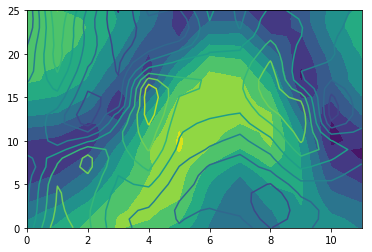

In [103]:
plt.contourf(shearmean.transpose())
plt.contour(strend_ns.transpose())

In [93]:
qlist

array([ 0.        , -0.29638348, -0.08189034,  0.16101647,  0.08703618,
       -0.13186477, -0.22337579, -0.54480832, -0.38505567, -0.64384849,
       -0.50532894,  0.        ])

/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Tmax_loc 9 11.9
Mean tgrad 6.314068
mean shear 11.230256575288049
shear lat 4.8999996 aej lat 3.84
linear regression for mcs cover 3 -0.06426618560021666 -0.455006769071574 0.006027041030906893
corr with mid level q (0.16542711906883806, 0.349797882831805)
corr with q (-0.17028317685326855, 0.33563268326729123)
corr with shear (-0.6808701464418891, 9.357977595742473e-06)
stddev q 0.5375041829391102
stddev shear 1.6517013313974986
Tmax_loc 13 14.7
Mean tgrad 8.391261
mean shear 9.260620926038012
shear lat 7.359999 aej lat 9.339999
linear regression for mcs cover 10 -0.07758625682328592 -0.7098284675440041 1.7958147174287498e-06
corr with mid level q (-0.13480239879152012, 0.44719184544678214)
corr with q (-0.6399590204153899, 4.591081536140512e-05)
corr with shear (0.08343713587375735, 0.6389698706774809)
stddev q 0.28638731228389486
stddev shear 0.996228598258542


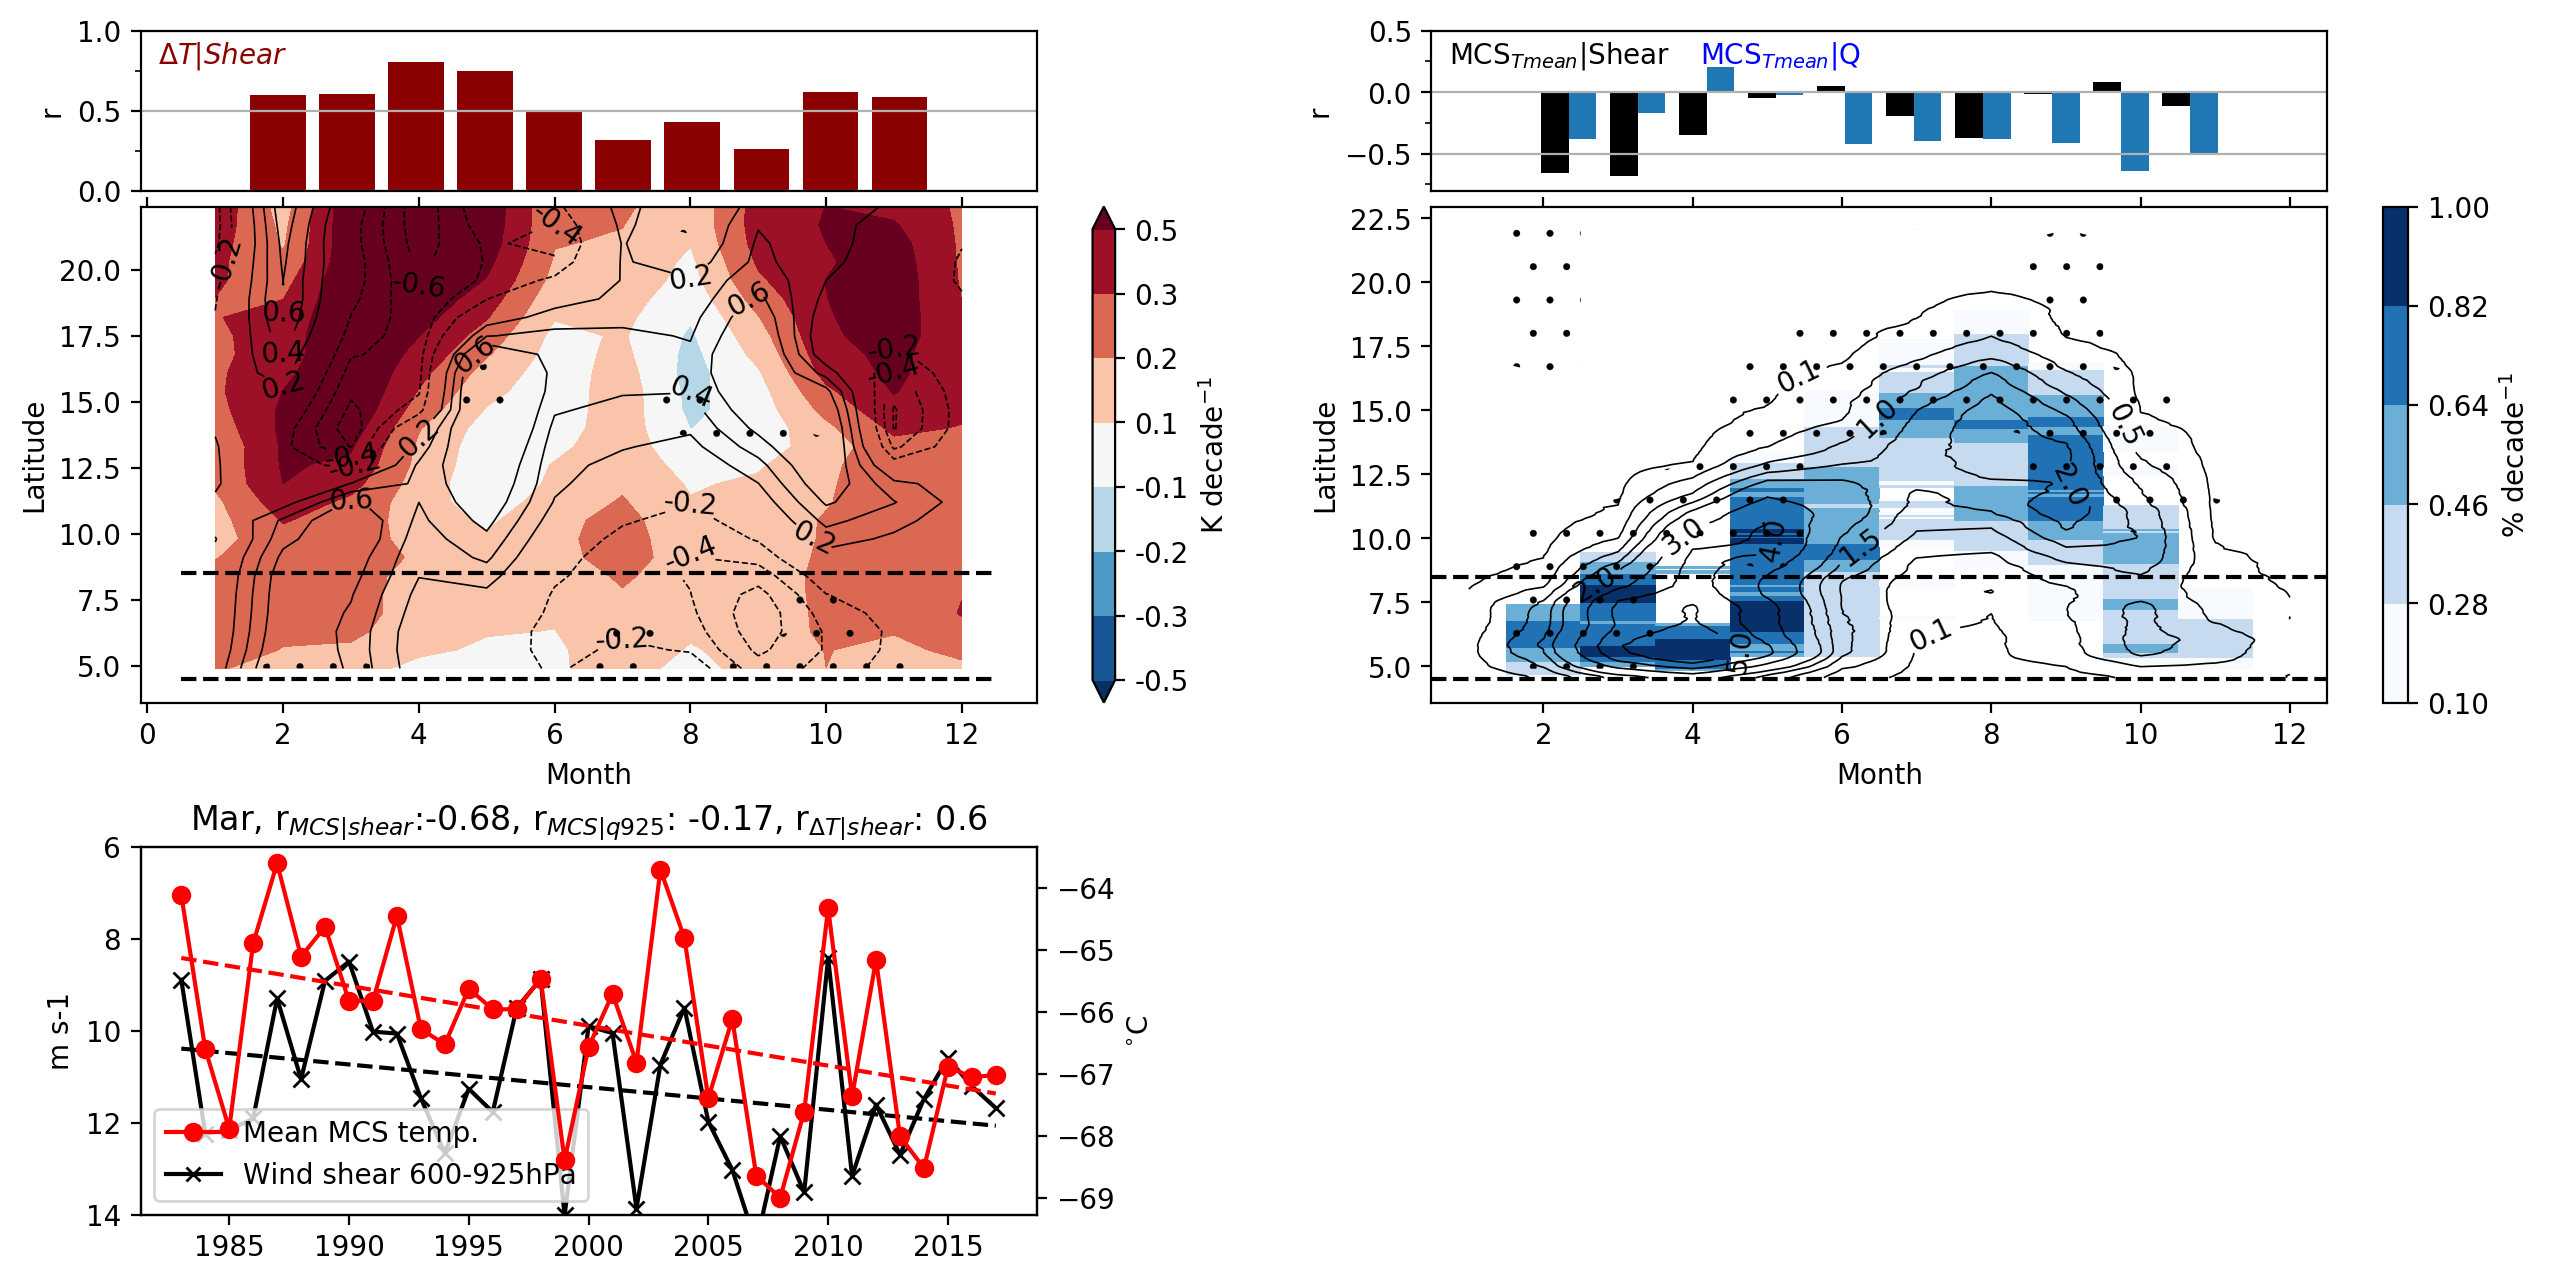

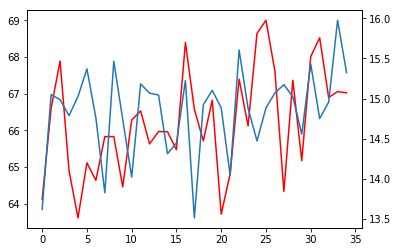

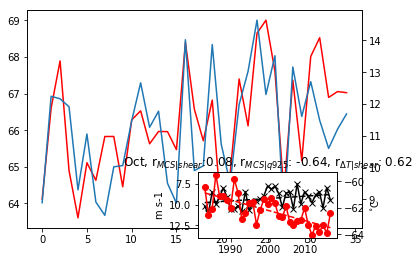

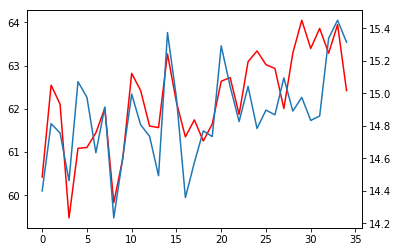

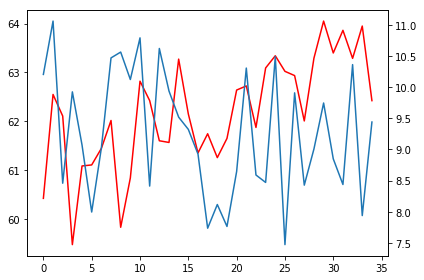

In [230]:
f=plt.figure(figsize=(14,8), dpi=200)  # this opens a plot window


left, width, width2 = 0.061, 0.4, 0.32
bottom, height, height2 = 0.09, 0.31, 0.23
space1=0.09
space2=0.01
bottom_h = bottom+height2+space1
bottom_h2 = bottom+height + height2 +space1+space2

rect_scatter1 = [left, bottom_h, width, height]
rect_scatter2 = [left+width+left, bottom_h, width, height]

rect_histx1 = [left, bottom_h2, width2, 0.1]
rect_histx2 = [left+width+left, bottom_h2, width2, 0.1]

line1 = [left, bottom, width2, height2]
line2 = [left+width+left, bottom, width2, height2]

#ax = f.add_subplot(221) #plt.axes(rect_histx1) #  # this opens a new plot axis
ax = plt.axes(rect_histx1)

bbar = ax.bar(ttrend.month,rlist, align='center', color='darkred')
ax.set_ylim(0,1)
plt.gca().set_xticks([])
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.grid(True)
plt.ylabel('r')
ax.text(0.02,0.8,'${\Delta T|Shear}$', color='darkred', transform=ax.transAxes)

qlistt = np.array(qlist).copy()
# qlistt[8] = qlistt[8]-0.3
# qlistt[7] = qlistt[7]-0.1

ax1 = plt.axes(rect_histx2)

bbar = ax1.bar(ttrend.month-0.2,np.array(ulist)*-1, align='center', width=0.4,color='k') # mlist
bbar = ax1.bar(ttrend.month+0.2,qlistt, align='center', width=0.4)
plt.gca().set_xticks([])
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))

ax1.grid(True)
plt.ylabel('r')
ax1.text(0.02,0.8,'MCS$_{Tmean}$|Shear', color='k', transform=ax1.transAxes)
ax1.text(0.3,0.8,'MCS$_{Tmean}$|Q', color='b', transform=ax1.transAxes)
ax1.set_ylim(-0.8,0.5)

ax2 = plt.axes(rect_scatter1)
mapp = ax2.contourf(ttrend.month, era_trend.latitude, ttrend.transpose(),                   
                   cmap='RdBu_r', extend='both', levels=np.linspace(-0.45,0.45,8))  # this is the actual plot

  # this is the actual plot

mpl.rcParams['hatch.linewidth'] = 0.1

## mask for significance indicator
if mask_sig is not None:
     plt.contourf(ttrend.month, era_trend.latitude, mask_sig, colors='none', hatches='..',
                 levels=[0.5, 1], linewidth=0.1)  
        
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
        
        
## additional contour on plot   
# if contour is not None:
#     cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
#                     cmap=contour['cmap'] ) 

#    plt.clabel(cs, inline=1, fontsize=10)

## additional contour on plot   
if contour is not None:
    cs = ax2.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                    colors=contour['colors'] , linewidths=0.6) 

    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f") #"%d"

#plt.title('Trends in T925 (shading) and shear (contour)')

plt.hlines(4.5,0.5,12.5, linestyles='dashed', color='k')
plt.hlines(8.5,0.5,12.5, linestyles='dashed', color='k')
plt.xlabel('Month')
plt.ylabel('Latitude')
# Countries
cbar = plt.colorbar(mapp, format="%1.1f", )  # adds colorbar
cbar.set_label( 'K decade$^{-1}$')

###############################

#ax = f.add_subplot(222)#plt.axes(rect_histx2)#f.add_subplot(222)  # this opens a new plot axis
ax3 = plt.axes(rect_scatter2)

cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


# mappable = ax3.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
#                           ,cmap=cmapp, vmin=0.05, vmax=0.80)

mappable = ax3.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose()
                          ,cmap=cmapp, vmin=0.1, vmax=1)

cbar = plt.colorbar(mappable, ticks=np.linspace(0.1,1,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('% decade$^{-1}$')
plt.hlines(4.5,0.5,12.5, linestyles='dashed')
plt.hlines(8.5,0.5,12.5, linestyles='dashed')
plt.xlabel('Month')
plt.ylabel('Latitude')

ax3.contourf(ttrend.month, era_trend.latitude, mask_sig2, colors='none', hatches='.',
                 levels=[0.5, 1], linewidth=0.05)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

#plt.title('Trends in -70C MCS-cover(shading) and mean shear (contour)')

#ipdb.set_trace()
# cs = ax.contour(np.arange(0.5,12,1), np.arange(0,25,1), mean.sel(lat=slice(0,25)), cmap='viridis' , levels=np.arange(0.5,4.5,1.5)) 
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

# mapp = ax.contour(ttrend.month, era_trend.latitude, umean.transpose(), 
#                    cmap='Reds', extend='both', levels=np.linspace(-10,-5,3), linestyles='dashed')  # this is the actual plot
# plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")

if contour2 is not None:
    cs = ax3.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                    colors=contour2['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
    
if contour3 is not None:    
    cs = ax3.contour(contour3['x'], contour3['y'], contour3['data'], levels=contour3['levels'], 
                    colors=contour3['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

################################

#ax = f.add_subplot(223)  # this opens a new plot axis
ax4 = plt.axes(line1)
m = 3
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax4.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax4.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
ax4.set_ylim(6,14)
ax4.set_ylim(ax4.get_ylim()[::-1])
ax5 = ax4.twinx()
ax5.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax5.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax5.set_ylabel('$^{\circ}$C')
ax4.set_ylabel('m s-1')

ax4.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$: ' + str(np.round(monthdic[10][0], decimals=2)))
if m==3:
    ax4.legend(handles=[mcsline, shearline], loc='lower left')
    
#################################
ax6 = plt.axes(line2)
#ax = f.add_subplot(224)  # this opens a new plot axis
m = 10
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax6.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax6.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
#ax.set_ylim(-15,-5)

ax6.set_ylim(6,14)
ax6.set_ylim(ax6.get_ylim()[::-1])

ax7 = ax6.twinx()
ax7.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax7.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax7.set_ylabel('$^{\circ}$C')
ax6.set_ylabel('m s-1')


ax6.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$'': ' + str(np.round(monthdic[10][0], decimals=2)))
if m==3:
    ax6.legend(handles=[mcsline, shearline], loc='lower left')
    
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/fig1_0.jpg')

In [570]:
contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose().values,  # /shearmean.transpose().values)*100
           'levels' : [-0.6,-0.4,-0.2,0.2,0.4, 0.6] , 'cmap' : 'viridis', 'colors' : 'k'} #  [-0.5,-0.3,-0.1,0.1,0.3,0.5] np.array([-14,-8,-2,2,8,14])

# contour3 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : shearmean.transpose(), 
#             'levels' : np.linspace(np.min(shearmean),np.max(shearmean),6), 'cmap' : 'Greys', 'colors' : 'r'} #np.array([-0.75, -0.6, -0.45])*-1

contour2 = {'x' : cmean.month, 'y' : cmean.lat, 'data' : cmean.transpose(),  #qmean.transpose()
           'levels' : [0.1,0.5,1,1.5,2,3,4,5], 'cmap' : 'Greys', 'colors' : 'k'} #np.array([-0.75, -0.6, -0.45])*-1

# contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : qmtrend.transpose(),  #qmean.transpose()
#            'levels' : np.linspace(0,0.5,6), 'cmap' : 'Greys', 'colors' : 'k'}


contour3 = None
mask_sig = (qtrend.transpose()>0.1).astype(int) 

mask_sig2 = (strend_ns.transpose()>0.3).astype(int) 
#mask_sig2 = (strend_ns.transpose()>0.1).astype(int) 

/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


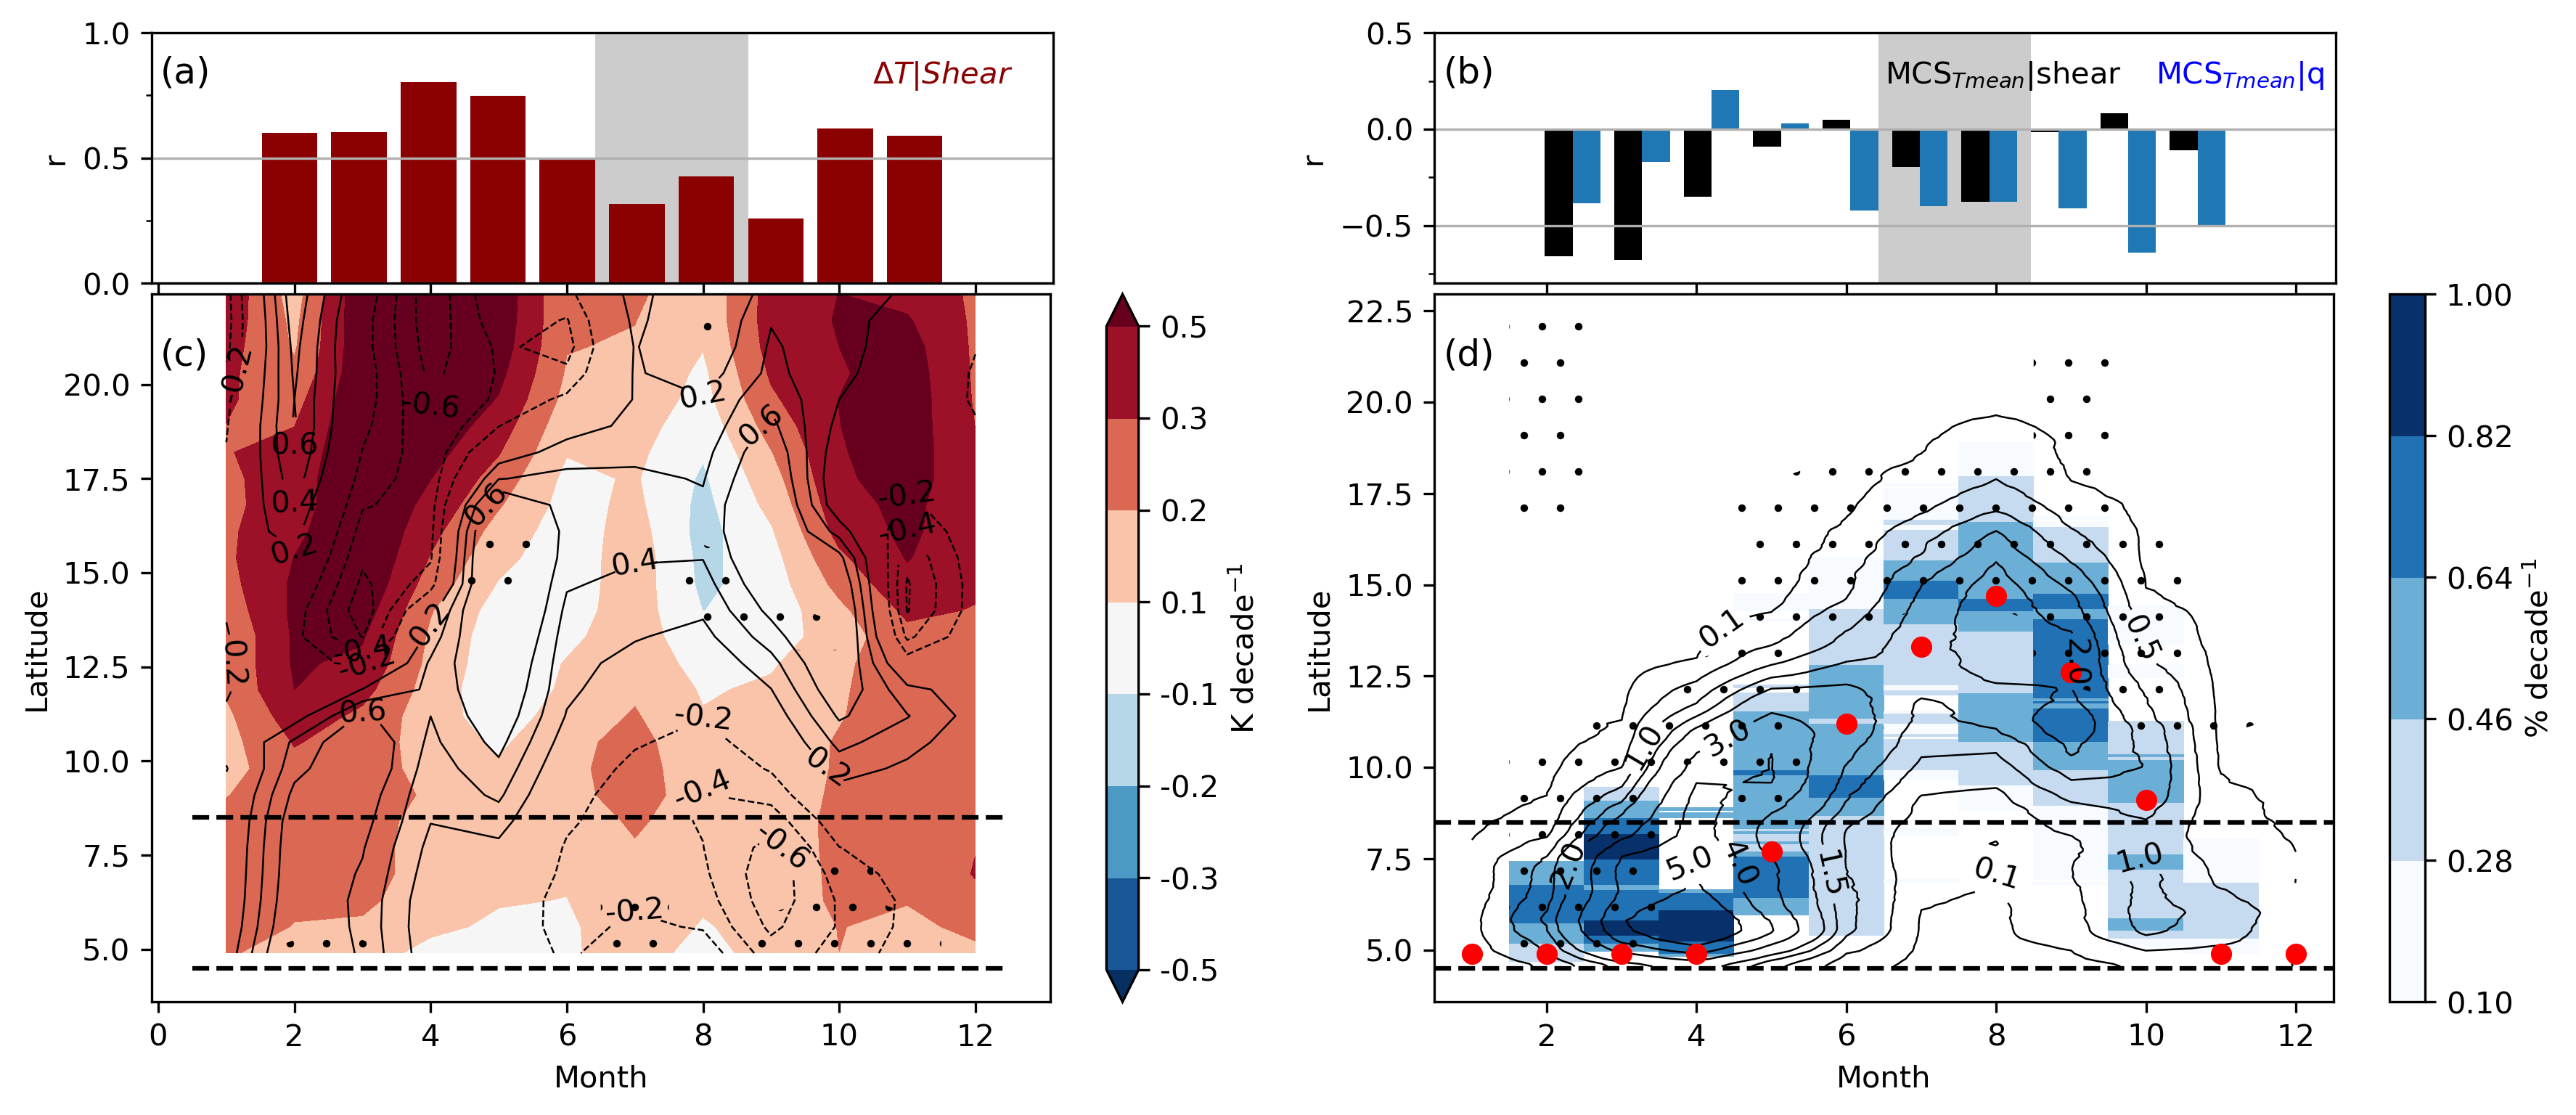

In [591]:
f=plt.figure(figsize=(12,5), dpi=300)  # this opens a plot window


left, width, width2 = 0.061, 0.43, 0.345
bottom, height, height2 = 0.09, 0.65, 0.23
space1=0.01

bottom_h2 = bottom+height +space1

rect_scatter1 = [left, bottom, width, height]
rect_scatter2 = [left+width+left, bottom, width, height]

rect_histx1 = [left, bottom_h2, width2, height2]
rect_histx2 = [left+width+left, bottom_h2, width2, height2]

#ax = f.add_subplot(221) #plt.axes(rect_histx1) #  # this opens a new plot axis
ax = plt.axes(rect_histx1)
ax.axvspan(6.4,8.6,facecolor='grey', alpha=0.4, zorder=1)
bbar = ax.bar(ttrend.month,rlist, align='center', color='darkred')
ax.set_ylim(0,1)
plt.gca().set_xticks([])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.grid(True)
plt.ylabel('r')
ax.text(0.8,0.8,'${\Delta T|Shear}$', color='darkred', transform=ax.transAxes)
ax.text(0.01,0.8,'(a)', transform=ax.transAxes, fontsize=12)

qlistt = np.array(qlist).copy()

ax1 = plt.axes(rect_histx2)
ax1.axvspan(6.4,8.6,facecolor='grey', alpha=0.4, zorder=1)
bbar = ax1.bar(ttrend.month-0.2,np.array(ulist)*-1, align='center', width=0.4,color='k') # mlist
bbar = ax1.bar(ttrend.month+0.2,qlistt, align='center', width=0.4)

plt.gca().set_xticks([])
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))
ax1.grid(True)
plt.ylabel('r')
ax1.text(0.5,0.8,'MCS$_{Tmean}$|shear', color='k', transform=ax1.transAxes)
ax1.text(0.8,0.8,'MCS$_{Tmean}$|q', color='b', transform=ax1.transAxes)
ax1.text(0.01,0.8,'(b)', transform=ax1.transAxes, fontsize=12)
ax1.set_ylim(-0.8,0.5)

ax2 = plt.axes(rect_scatter1)
mapp = ax2.contourf(ttrend.month, era_trend.latitude, ttrend.transpose(),                   
                   cmap='RdBu_r', extend='both', levels=np.linspace(-0.45,0.45,8))  # this is the actual plot

  # this is the actual plot

mpl.rcParams['hatch.linewidth'] = 0.1

## mask for significance indicator
if mask_sig is not None:
     plt.contourf(ttrend.month, era_trend.latitude, mask_sig, colors='none', hatches='..',
                 levels=[0.5, 1], linewidth=0.1)  
        
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
ax2.text(0.01,0.9,'(c)', transform=ax2.transAxes, fontsize=12)        
        
## additional contour on plot   
# if contour is not None:
#     cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
#                     cmap=contour['cmap'] ) 

#    plt.clabel(cs, inline=1, fontsize=10)

## additional contour on plot   
if contour is not None:
    cs = ax2.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                    colors=contour['colors'] , linewidths=0.6) 

    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f") #"%d"

#plt.title('Trends in T925 (shading) and shear (contour)')

plt.hlines(4.5,0.5,12.5, linestyles='dashed', color='k')
plt.hlines(8.5,0.5,12.5, linestyles='dashed', color='k')
plt.xlabel('Month')
plt.ylabel('Latitude')
# Countries
cbar = plt.colorbar(mapp, format="%1.1f", )  # adds colorbar
cbar.set_label( 'K decade$^{-1}$')

###############################

#ax = f.add_subplot(222)#plt.axes(rect_histx2)#f.add_subplot(222)  # this opens a new plot axis
ax3 = plt.axes(rect_scatter2)
ax3.text(0.01,0.9,'(d)', transform=ax3.transAxes, fontsize=12)
cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


# mappable = ax3.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
#                           ,cmap=cmapp, vmin=0.05, vmax=0.80)

mappable = ax3.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose()
                          ,cmap=cmapp, vmin=0.1, vmax=1)

#ipdb.set_trace()
ax3.plot(ttrend.month,era_trend.latitude.values[aej_pos],'ro')

cbar = plt.colorbar(mappable, ticks=np.linspace(0.1,1,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('% decade$^{-1}$')
plt.hlines(4.5,0.5,12.5, linestyles='dashed')
plt.hlines(8.5,0.5,12.5, linestyles='dashed')
plt.xlabel('Month')
plt.ylabel('Latitude')

ax3.contourf(ttrend.month, era_trend.latitude, mask_sig2, colors='none', hatches='.',
                 levels=[0.5, 1], linewidth=0.05)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

#plt.title('Trends in -70C MCS-cover(shading) and mean shear (contour)')

#ipdb.set_trace()
# cs = ax.contour(np.arange(0.5,12,1), np.arange(0,25,1), mean.sel(lat=slice(0,25)), cmap='viridis' , levels=np.arange(0.5,4.5,1.5)) 
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

# mapp = ax.contour(ttrend.month, era_trend.latitude, umean.transpose(), 
#                    cmap='Reds', extend='both', levels=np.linspace(-10,-5,3), linestyles='dashed')  # this is the actual plot
# plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")

if contour2 is not None:
    cs = ax3.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                    colors=contour2['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
    
if contour3 is not None:    
    cs = ax3.contour(contour3['x'], contour3['y'], contour3['data'], levels=contour3['levels'], 
                    colors=contour3['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

    
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/fig1_2_q2.jpg')

In [124]:
contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose().values,  # /shearmean.transpose().values)*100
           'levels' : [-0.6,-0.4,-0.2,0.2,0.4, 0.6] , 'cmap' : 'viridis', 'colors' : 'k'} #  [-0.5,-0.3,-0.1,0.1,0.3,0.5] np.array([-14,-8,-2,2,8,14])

# contour3 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : shearmean.transpose(), 
#             'levels' : np.linspace(np.min(shearmean),np.max(shearmean),6), 'cmap' : 'Greys', 'colors' : 'r'} #np.array([-0.75, -0.6, -0.45])*-1

contour2 = {'x' : cmean.month, 'y' : cmean.lat, 'data' : cmean.transpose(),  #qmean.transpose()
           'levels' : [0.1,0.5,1,1.5,2,2.5,3,3.5], 'cmap' : 'Greys', 'colors' : 'k'} #np.array([-0.75, -0.6, -0.45])*-1

# contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : qmtrend.transpose(),  #qmean.transpose()
#            'levels' : np.linspace(0,0.5,6), 'cmap' : 'Greys', 'colors' : 'k'}


contour3 = None
mask_sig = (qtrend.transpose()>0.1).astype(int) 

mask_sig2 = (strend_ns.transpose()>0.3).astype(int) 
#mask_sig2 = (strend_ns.transpose()>0.1).astype(int) 

In [ ]:
tcwvtrend.values.max()

In [ ]:
divmean.transpose()*100000

In [ ]:
f=plt.figure(figsize=(14,17), dpi=200)  # this opens a plot window

contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : strend_ns.transpose().values,  # /shearmean.transpose().values)*100
           'levels' : [-0.6,-0.4,-0.2,0.2,0.4, 0.6] , 'cmap' : 'viridis', 'colors' : 'k'} #  [-0.5,-0.3,-0.1,0.1,0.3,0.5] np.array([-14,-8,-2,2,8,14])

# contour3 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : shearmean.transpose(), 
#             'levels' : np.linspace(np.min(shearmean),np.max(shearmean),6), 'cmap' : 'Greys', 'colors' : 'r'} #np.array([-0.75, -0.6, -0.45])*-1

contour2 = {'x' : cmean.month, 'y' : cmean.lat, 'data' : cmean.transpose(),  #qmean.transpose()
           'levels' : np.linspace(0.1,2,6), 'cmap' : 'Greys', 'colors' : 'k'} #np.array([-0.75, -0.6, -0.45])*-1

# contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : qmtrend.transpose(),  #qmean.transpose()
#            'levels' : np.linspace(0,0.5,6), 'cmap' : 'Greys', 'colors' : 'k'}


contour3 = None
mask_sig = (qtrend.transpose()>0.1).astype(int) 

mask_sig2 = (strend_ns.transpose()>0.3).astype(int) 

left, width, width2 = 0.061, 0.4, 0.32
bottom, height, height2 = 0.09, 0.31, 0.31
space1=0.09
space2=0.01
bottom_h = bottom+height2+space1
bottom_h2 = bottom+height + height2 +space1+space2

rect_scatter1 = [left, bottom_h, width, height]
rect_scatter2 = [left+width+left, bottom_h, width, height]

rect_histx1 = [left, bottom_h2, width2, 0.1]
rect_histx2 = [left+width+left, bottom_h2, width2, 0.1]

line1 = [left, bottom, width, height2]
line2 = [left+width+left, bottom, width, height2]

#ax = f.add_subplot(221) #plt.axes(rect_histx1) #  # this opens a new plot axis
ax = plt.axes(rect_histx1)

bbar = ax.bar(ttrend.month,rlist, align='center', color='darkred')
ax.set_ylim(0,1)
plt.gca().set_xticks([])
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.grid(True)
plt.ylabel('r')
ax.text(0.02,0.8,'${\Delta T|Shear}$', color='darkred', transform=ax.transAxes)

qlistt = np.array(qlist).copy()
# qlistt[8] = qlistt[8]-0.3
# qlistt[7] = qlistt[7]-0.1

ax1 = plt.axes(rect_histx2)

bbar = ax1.bar(ttrend.month-0.2,np.array(ulist)*-1, align='center', width=0.4,color='k') # mlist
bbar = ax1.bar(ttrend.month+0.2,qlistt, align='center', width=0.4)
plt.gca().set_xticks([])
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))

ax1.grid(True)
plt.ylabel('r')
ax1.text(0.02,0.8,'MCS$_{Tmean}$|Shear', color='k', transform=ax1.transAxes)
ax1.text(0.3,0.8,'MCS$_{Tmean}$|Q', color='b', transform=ax1.transAxes)
ax1.set_ylim(-0.8,0.5)

ax2 = plt.axes(rect_scatter1)
mapp = ax2.contourf(ttrend.month, era_trend.latitude, ttrend.transpose(),                   
                   cmap='RdBu_r', extend='both', levels=np.linspace(-0.45,0.45,8))  # this is the actual plot

  # this is the actual plot

mpl.rcParams['hatch.linewidth'] = 0.1

## mask for significance indicator
if mask_sig is not None:
     plt.contourf(ttrend.month, era_trend.latitude, mask_sig, colors='none', hatches='..',
                 levels=[0.5, 1], linewidth=0.1)  
        
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
        
        
## additional contour on plot   
# if contour is not None:
#     cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
#                     cmap=contour['cmap'] ) 

#    plt.clabel(cs, inline=1, fontsize=10)

## additional contour on plot   
if contour is not None:
    cs = ax2.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                    colors=contour['colors'] , linewidths=0.6) 

    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f") #"%d"

#plt.title('Trends in T925 (shading) and shear (contour)')

plt.hlines(4.5,0.5,12.5, linestyles='dashed', color='k')
plt.hlines(8.5,0.5,12.5, linestyles='dashed', color='k')
plt.xlabel('Month')
plt.ylabel('Latitude')
# Countries
cbar = plt.colorbar(mapp, format="%1.1f", )  # adds colorbar
cbar.set_label( 'K decade$^{-1}$')

###############################

#ax = f.add_subplot(222)#plt.axes(rect_histx2)#f.add_subplot(222)  # this opens a new plot axis
ax3 = plt.axes(rect_scatter2)

cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


# mappable = ax3.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
#                           ,cmap=cmapp, vmin=0.05, vmax=0.80)

mappable = ax3.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose()
                          ,cmap=cmapp, vmin=0.1, vmax=1)

cbar = plt.colorbar(mappable, ticks=np.linspace(0.1,1,6)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('% decade$^{-1}$')
plt.hlines(4.5,0.5,12.5, linestyles='dashed')
plt.hlines(8.5,0.5,12.5, linestyles='dashed')
plt.xlabel('Month')
plt.ylabel('Latitude')

ax3.contourf(ttrend.month, era_trend.latitude, mask_sig2, colors='none', hatches='.',
                 levels=[0.5, 1], linewidth=0.05)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

#plt.title('Trends in -70C MCS-cover(shading) and mean shear (contour)')

#ipdb.set_trace()
# cs = ax.contour(np.arange(0.5,12,1), np.arange(0,25,1), mean.sel(lat=slice(0,25)), cmap='viridis' , levels=np.arange(0.5,4.5,1.5)) 
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

# mapp = ax.contour(ttrend.month, era_trend.latitude, umean.transpose(), 
#                    cmap='Reds', extend='both', levels=np.linspace(-10,-5,3), linestyles='dashed')  # this is the actual plot
# plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")

if contour2 is not None:
    cs = ax3.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                    colors=contour2['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
    
if contour3 is not None:    
    cs = ax3.contour(contour3['x'], contour3['y'], contour3['data'], levels=contour3['levels'], 
                    colors=contour3['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

################################
################################
################################ New part

contour = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : (divmean.transpose().values)*100000,  # /shearmean.transpose().values)*100
           'levels' : np.linspace(-5,5,8) , 'cmap' : 'viridis', 'colors' : 'k'} #  [-0.5,-0.3,-0.1,0.1,0.3,0.5] np.array([-14,-8,-2,2,8,14])

# contour3 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : shearmean.transpose(), 
#             'levels' : np.linspace(np.min(shearmean),np.max(shearmean),6), 'cmap' : 'Greys', 'colors' : 'r'} #np.array([-0.75, -0.6, -0.45])*-1

contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : tcwvmean.transpose(),  #qmean.transpose()
           'levels' : np.linspace(35,50,8), 'cmap' : 'Greys', 'colors' : 'k'} #np.array([-0.75, -0.6, -0.45])*-1

# contour2 = {'x' : ttrend.month, 'y' : era_trend.latitude, 'data' : qmtrend.transpose(),  #qmean.transpose()
#            'levels' : np.linspace(0,0.5,6), 'cmap' : 'Greys', 'colors' : 'k'}


contour3 = None
mask_sig = (qtrend.transpose()>0.1).astype(int) 

mask_sig2 = (strend_ns.transpose()>0.3).astype(int) 
#mask_sig2 = (strend_ns.transpose()>0.1).astype(int) 

ax4 = plt.axes(line1)
mapp = ax4.contourf(ttrend.month, era_trend.latitude, qdiv_trend.transpose()*100000,                   
                   cmap='RdBu', extend='both', levels=np.linspace(-0.5,0.5,8))  # this is the actual plot

  # this is the actual plot

mpl.rcParams['hatch.linewidth'] = 0.1

# ## mask for significance indicator
# if mask_sig is not None:
#      plt.contourf(ttrend.month, era_trend.latitude, mask_sig, colors='none', hatches='..',
#                  levels=[0.5, 1], linewidth=0.1)  
        
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
        
        
## additional contour on plot   
# if contour is not None:
#     cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
#                     cmap=contour['cmap'] ) 

#    plt.clabel(cs, inline=1, fontsize=10)

## additional contour on plot   
if contour is not None:
    cs = ax4.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], 
                    colors=contour['colors'] , linewidths=0.6) 

    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f") #"%d"

#plt.title('Trends in T925 (shading) and shear (contour)')

plt.hlines(4.5,0.5,12.5, linestyles='dashed', color='k')
plt.hlines(8.5,0.5,12.5, linestyles='dashed', color='k')
plt.xlabel('Month')
plt.ylabel('Latitude')
# Countries
cbar = plt.colorbar(mapp, format="%1.1f", )  # adds colorbar
cbar.set_label( 'K decade$^{-1}$')

###############################

#ax = f.add_subplot(222)#plt.axes(rect_histx2)#f.add_subplot(222)  # this opens a new plot axis
ax5 = plt.axes(line2)

cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


# mappable = ax3.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
#                           ,cmap=cmapp, vmin=0.05, vmax=0.80)

mapp = ax5.contourf(ttrend.month, era_trend.latitude,tcwvtrend.transpose(),                   
                   cmap='RdBu', extend='both', levels=np.linspace(-1,1,8))  # this is the actual plot

cbar = plt.colorbar(mapp) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
cbar.set_label('% decade$^{-1}$')
plt.hlines(4.5,0.5,12.5, linestyles='dashed')
plt.hlines(8.5,0.5,12.5, linestyles='dashed')
plt.xlabel('Month')
plt.ylabel('Latitude')

ax3.contourf(ttrend.month, era_trend.latitude, mask_sig2, colors='none', hatches='.',
                 levels=[0.5, 1], linewidth=0.05)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

#plt.title('Trends in -70C MCS-cover(shading) and mean shear (contour)')

#ipdb.set_trace()
# cs = ax.contour(np.arange(0.5,12,1), np.arange(0,25,1), mean.sel(lat=slice(0,25)), cmap='viridis' , levels=np.arange(0.5,4.5,1.5)) 
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

# mapp = ax.contour(ttrend.month, era_trend.latitude, umean.transpose(), 
#                    cmap='Reds', extend='both', levels=np.linspace(-10,-5,3), linestyles='dashed')  # this is the actual plot
# plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")

if contour2 is not None:
    cs = ax5.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], 
                    colors=contour2['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
    
if contour3 is not None:    
    cs = ax5.contour(contour3['x'], contour3['y'], contour3['data'], levels=contour3['levels'], 
                    colors=contour3['colors'] , linewidths=0.6) 
    plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
    
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/fig1_3.jpg')

Tmax_loc 9 11.9
Mean tgrad 6.314068
mean shear 11.230256575288049
shear lat 4.8999996 aej lat 3.84
linear regression for mcs cover 3 -0.06426618560021666 -0.455006769071574 0.006027041030906893
corr with mid level q (0.16542711906883806, 0.349797882831805)
corr with q (-0.17028317685326855, 0.33563268326729123)
corr with shear (-0.7237931344251427, 1.314964790854762e-06)
stddev q 0.5375041829391102
stddev shear 1.6517013313974986
Tmax_loc 13 14.7
Mean tgrad 8.391261
mean shear 9.260620926038012
shear lat 7.359999 aej lat 9.339999
linear regression for mcs cover 10 -0.07758625682328592 -0.7098284675440041 1.7958147174287498e-06
corr with mid level q (-0.13480239879152012, 0.44719184544678214)
corr with q (-0.6399590204153899, 4.591081536140512e-05)
corr with shear (0.010303043938694655, 0.9538833488708723)
stddev q 0.28638731228389486
stddev shear 0.996228598258542
Tmax_loc 9 11.9
Mean tgrad 6.314068
mean shear 11.230256575288049
shear lat 4.8999996 aej lat 3.84
linear regression for mc

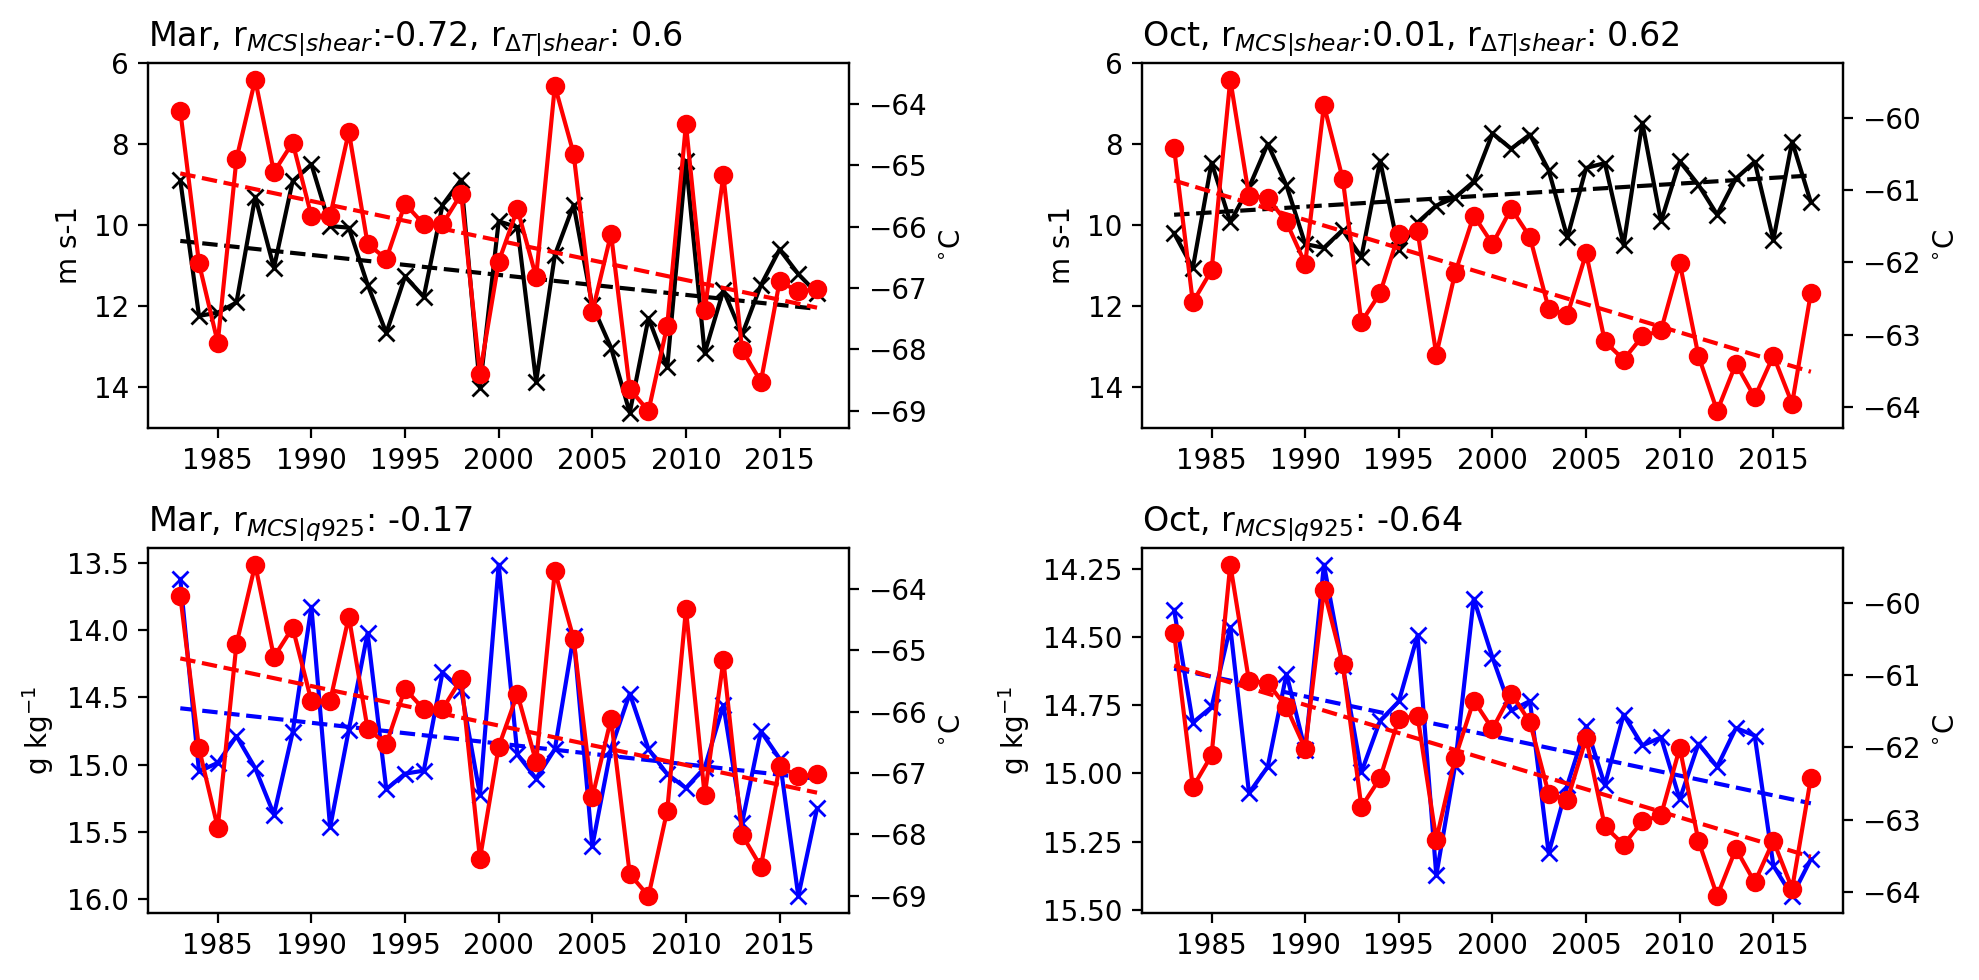

In [13]:
################################
f=plt.figure(figsize=(10,5), dpi=200)  # this opens a plot window

ax4 = f.add_subplot(221)  # this opens a new plot axis
#ax4 = plt.axes(line1)
m = 3
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax4.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax4.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
ax4.set_ylim(6,15)
ax4.set_ylim(ax4.get_ylim()[::-1])
ax5 = ax4.twinx()
ax5.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax5.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax5.set_ylabel('$^{\circ}$C')
ax4.set_ylabel('m s-1')

ax4.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) + ', r$_{\Delta T|shear}$: ' + str(np.round(monthdic[10][0], decimals=2)), loc='left')
# if m==3:
#     ax4.legend(handles=[mcsline, shearline], loc='lower left')
    
#################################
#ax6 = plt.axes(line2)
ax6 = f.add_subplot(222)  # this opens a new plot axis
m = 10
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[4][0]
ax6.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
ax6.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
#ax.set_ylim(-15,-5)

ax6.set_ylim(6,15)
ax6.set_ylim(ax6.get_ylim()[::-1])

ax7 = ax6.twinx()
ax7.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax7.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax7.set_ylabel('$^{\circ}$C')
ax6.set_ylabel('m s-1')


ax6.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2))  + ', r$_{\Delta T|shear}$'': ' + str(np.round(monthdic[10][0], decimals=2)), loc='left')


ax8 = f.add_subplot(223)  # this opens a new plot axis
#ax4 = plt.axes(line1)
m = 3
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[6][0]
ax8.plot(monthdic[7].year, monthdic[11], 'x-', label='925hPa specific humidity', color='b')
ax8.plot(monthdic[7].year, monthdic[15] + x*monthdic[14], '--', color='b')
#ax8.set_ylim(13,17)
ax8.set_ylim(ax8.get_ylim()[::-1])
ax9 = ax8.twinx()
ax9.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax9.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax9.set_ylabel('$^{\circ}$C')
ax8.set_ylabel('g kg$^{-1}$')

ax8.set_title(monthdic[5]+', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)), loc='left')
# if m==3:
#     ax8.legend(handles=[mcsline, shearline], loc='lower left')
    
#################################
#ax6 = plt.axes(line2)
ax1 = f.add_subplot(224)  # this opens a new plot axis
m = 10
monthdic = calc_month(m)

x = np.arange(0,len(monthdic[0]))
rr = monthdic[6][0]
ax1.plot(monthdic[7].year, monthdic[11], 'x-', label='925hPa specific humidity', color='b')
ax1.plot(monthdic[7].year, monthdic[15] + x*monthdic[14], '--', color='b')
#ax.set_ylim(-15,-5)

#ax1.set_ylim(13,17)
ax1.set_ylim(ax1.get_ylim()[::-1])

ax2 = ax1.twinx()
ax2.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
ax2.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
ax2.set_ylabel('$^{\circ}$C')
ax1.set_ylabel('g kg$^{-1}$')


ax1.set_title(monthdic[5]+', r$_{MCS|q925}$: ' 
             + str(np.round(monthdic[6][0], decimals=2)), loc='left')

plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_qshear_timeseries_marchOct.jpg')

In [ ]:
################################
f=plt.figure(figsize=(15,15), dpi=200)  # this opens a plot window

for ids, m in enumerate(range(3,12)):

    ax4 = f.add_subplot(3,3,ids+1)  # this opens a new plot axis
    #ax4 = plt.axes(line1)

    monthdic = calc_month(m)

    x = np.arange(0,len(monthdic[0]))
    rr = monthdic[4][0]
    ax4.plot(monthdic[7].year, monthdic[0], 'x-', label='Wind shear 600-925hPa', color='k')
    ax4.plot(monthdic[7].year, monthdic[2] + x*monthdic[3], '--', color='k')
    ax4.set_ylim(6,15)
    ax4.set_ylim(ax4.get_ylim()[::-1])
    ax5 = ax4.twinx()
    ax5.plot(monthdic[1]['time.year'],monthdic[1], 'o-', label='Mean MCS temp.', color='r')
    ax5.plot(monthdic[7].year, monthdic[8] + x*monthdic[9], '--', color='r')
    mcsline = lines.Line2D([],[], color='r', label='Mean MCS temp.', linestyle='solid', marker='o')
    shearline = lines.Line2D([],[], color='k', label='Wind shear 600-925hPa', linestyle='solid', marker='x', markersize=5)
    ax5.set_ylabel('$^{\circ}$C')
    ax4.set_ylabel('m s-1')

    ax4.set_title(monthdic[5]+', r$_{MCS|shear}$:'+ str(np.round(rr, decimals=2)) +', r$_{MCS|q925}$: ' 
                 + str(np.round(monthdic[6][0], decimals=2)) + ', r$_{\Delta T|shear}$: ' + str(np.round(monthdic[10][0], decimals=2)))
    # if m==3:
    #     ax4.legend(handles=[mcsline, shearline], loc='lower left')
  
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/CLOVER/fig_qshear_timeseries_marchOct.jpg')